In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# reflect the tables
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

'2017-08-23'

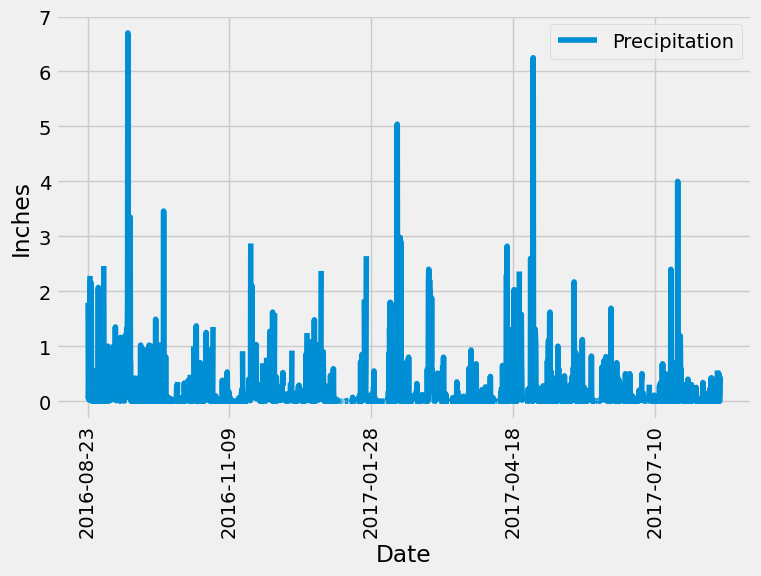

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
date1 = datetime.strptime(session.query(measurement.date).order_by(measurement.date.desc()).first()[0], '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
date2 = date1 - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
query_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= date2.strftime("%Y-%m-%d"), measurement.date <= date1.strftime("%Y-%m-%d"))

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(query_prcp.statement, engine)

# Sort the dataframe by date
df.sort_values(by = 'date', ascending = True, inplace=True)

df.set_index('date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize = [8,5])
plt.legend(['Precipitation'], loc = 1)
plt.xticks(rotation = 90)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
query_station_count = session.query(station.name.distinct()).count()
query_station_count

9

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_list = session.query(station.station).all()
station_names = session.query(station.name).all()

counts = []
for s in station_list:
    row_count = session.query(func.count(measurement.station)).filter(measurement.station == s[0]).all()
    counts.append(row_count[0][0])
    
df = pd.DataFrame({'station':station_list, 'name':station_names, 'count':counts})
df.sort_values(by='count', ascending=False, inplace=True)

for index, row in df.iterrows():
    print(f'Station \'{row["name"][0]}\' has {row["count"]} data points')


Station 'WAIHEE 837.5, HI US' has 2772 data points
Station 'WAIKIKI 717.2, HI US' has 2724 data points
Station 'KANEOHE 838.1, HI US' has 2709 data points
Station 'WAIMANALO EXPERIMENTAL FARM, HI US' has 2669 data points
Station 'MANOA LYON ARBO 785.2, HI US' has 2612 data points
Station 'KUALOA RANCH HEADQUARTERS 886.9, HI US' has 2202 data points
Station 'HONOLULU OBSERVATORY 702.2, HI US' has 1979 data points
Station 'PEARL CITY, HI US' has 1372 data points
Station 'UPPER WAHIAWA 874.3, HI US' has 511 data points


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
busy_station = df.iloc[0,0][0]
print(f'For station \'{df.iloc[0,0][0]}\':')
print(f'Lowest temperature: {session.query(func.min(measurement.tobs)).filter(measurement.station == busy_station).all()[0][0]}\u00b0F')
print(f'Highest temperature: {session.query(func.max(measurement.tobs)).filter(measurement.station == busy_station).all()[0][0]}\u00b0F')
print(f'Average temperature: {round(session.query(func.avg(measurement.tobs)).filter(measurement.station == busy_station).all()[0][0], 1)}\u00b0F')

For station 'USC00519281':
Lowest temperature: 54.0°F
Highest temperature: 85.0°F
Average temperature: 71.7°F


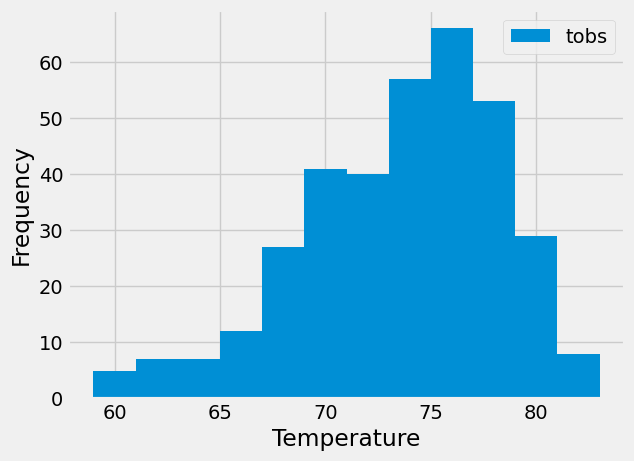

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query_tobs = session.query(measurement.tobs).filter(measurement.date >= date2.strftime("%Y-%m-%d"), measurement.date <= date1.strftime("%Y-%m-%d"), measurement.station == busy_station)
df2 = pd.read_sql(query_tobs.statement, engine)

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(df2, bins=12)
plt.legend(['tobs'])
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

# Close session

In [17]:
# Close Session
session.close()